In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import glob

import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path

import random
from sklearn.model_selection import StratifiedShuffleSplit



# crop masked part of image 

In [2]:
noon_dir = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/noon/'
noon_files = glob.glob(noon_dir+'*.jpg')
noon_filenames =[i.split('/')[-1] for i in noon_files]

# test_dir = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/test/'
# test_files = glob.glob(test_dir+'*.jpg')
# test_filenames =[i.split('/')[-1] for i in test_files]




In [3]:
len(noon_filenames)

1552

In [16]:
imag_sum = mpimg.imread(noon_dir+noon_filenames[0])[100:,:,:].astype(float)

In [19]:

for i in noon_filenames:
    imag = mpimg.imread(noon_dir+i)[100:,:,:]
    imag_sum += imag.astype(float)

In [25]:
imag_mean = np.mean(np.mean(imag_sum/len(noon_files),axis=0),axis=0)
print('mean', imag_mean)

mean [ 93.18228285 104.2707721   79.90378895]


In [4]:
out_dir  = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/'
Path(out_dir).mkdir(parents=True, exist_ok=True)

for i in noon_filenames:
    imag = mpimg.imread(noon_dir+i)[100:,:,:]
    im = Image.fromarray(imag)
    im.save(out_dir+i)



In [5]:
imag.shape

(860, 1296, 3)

In [30]:
processed_file = glob.glob(out_dir+'*.jpg')

NameError: name 'out_dir' is not defined

In [7]:
len(processed_file)

1552

# read in raw annotations

In [31]:
noon_anno_file = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Annotations/noon/niwot5-snow-full/manifests/output/output.manifest'
with open(noon_anno_file, 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]


In [32]:
confidence= {}
file_list  = []
for i in output:
    file = i['source-ref'].split('/')[-1]
    confidence[file] = i[list(i.keys())[2]]['confidence-map']
    file_list.append(file)
    

In [33]:
len(output)

1552

In [34]:
label_mean={}
for file in confidence.keys():
    label_confidence = confidence[file]
    labels = np.array(list(label_confidence.keys())).astype(int)
    weights = np.array([label_confidence[str(ll)] for ll in labels])
#     label_mean[file] = int(round(np.mean(labels)))
    label_mean[file] = int(round(np.dot(labels,weights)/np.sum(weights)))

In [35]:
labels_all = list(label_mean.values()) ## all labels list
label_1 = [file for file in label_mean.keys() if label_mean[file] == 1] # all files with label=1
label_0 = [file for file in label_mean.keys() if label_mean[file] == 0]# all files with label=0
np.random.seed(0)
label_1_selected = list(np.random.choice(label_1, len(label_0) )) # random choose files with label 1 and the number of files equals to the number of files with label=0
label_other = [file for file in label_mean.keys() if label_mean[file] != 1] # files with label != 1
files_selected = label_1_selected + label_other # all files after remove extra label 1's
labels_selected = {}
for file in files_selected:
    labels_selected[file] = label_mean[file]

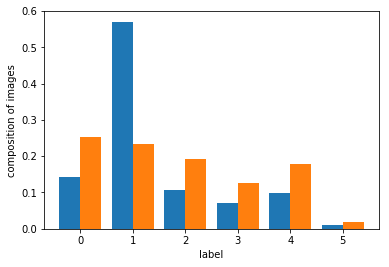

In [36]:
plt.hist([labels_all,list(labels_selected.values())], bins = np.arange(7)-0.5,density=True,color=['C0','C1'],label=['all images','balanced'])
plt.xlabel('label')
plt.ylabel('composition of images')
plt.savefig('../figures/label_histogram_winter_images.pdf')

In [37]:
json_object = json.dumps(label_mean)
with open('/net/fluo/data2/groupMembers/rccheng/PhenoCam/Annotations/annotations-all.json','w') as outfile:
    outfile.write(json_object)

In [38]:
json_object = json.dumps(labels_selected)
with open('/net/fluo/data2/groupMembers/rccheng/PhenoCam/Annotations/annotations-balanced.json','w') as outfile:
    outfile.write(json_object)

In [39]:
with open('/net/fluo/data2/groupMembers/rccheng/PhenoCam/Annotations/annotations-balanced.json', 'r') as openfile: 
  
    # Reading from json file 
    json_object2 = json.load(openfile) 
    

In [40]:
labels = np.array(list(json_object2.values()))

# Try load data to pytorch dataloader

In [41]:
#20% to test, 80% of the rest is for training and 20% of the rest is for testing

In [42]:
files = np.array(list(json_object2.keys()))
target = np.array([json_object2[i] for i in files])


In [43]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42)
# sss.get_n_splits(files,target)
for rest_idx, test_idx in sss.split(files,target):
    files_rest = files[rest_idx]
    files_test = files[test_idx]
    
    target_rest = target[rest_idx]
    target_test = target[test_idx]

for train_idx, validate_idx in sss.split(files_rest,target_rest):
    files_train = files_rest[train_idx]
    files_validate = files_rest[validate_idx]
    
    target_train = target_rest[train_idx]
    target_validate = target_rest[validate_idx]


    

(array([220.,   0., 202.,   0., 167.,   0., 109.,   0., 155.,  16.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

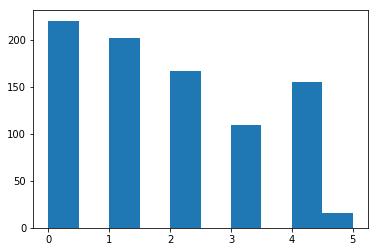

In [44]:
plt.hist(target)

(array([176.,   0., 161.,   0., 134.,   0.,  87.,   0., 124.,  13.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

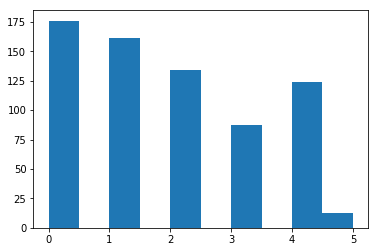

In [45]:
plt.hist(target_rest)

(array([44.,  0., 41.,  0., 33.,  0., 22.,  0., 31.,  3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

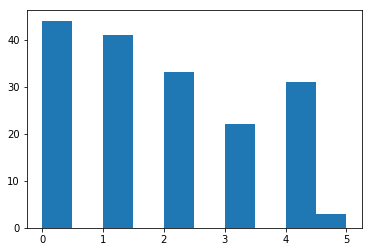

In [46]:
plt.hist(target_test)

(array([141.,   0., 129.,   0., 107.,   0.,  70.,   0.,  99.,  10.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

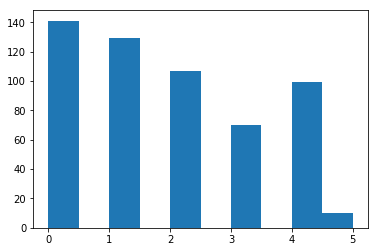

In [47]:
plt.hist(target_train)

(array([35.,  0., 32.,  0., 27.,  0., 17.,  0., 25.,  3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

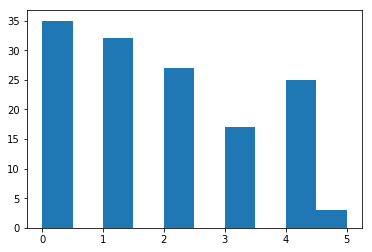

In [48]:
plt.hist(target_validate)

In [49]:
for i in range(len(files_test)):
    file = files_test[i]
    target = target_test[i]
    t_prime = json_object2[file]
    if target!=t_prime:
        print(file)

In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os

In [61]:
import os
class oversample(torch.utils.data.Dataset):
    def __init__(self, filenames, targets, directory, transform=None):
        self.filenames = filenames
        self.targets = targets
        self.dir = directory
        self.transform=transform
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self,idx):
        img_name = self.dir+ self.filenames[idx]
        image = np.array(Image.open(img_name))
        label = self.targets[idx]
        sample = {'image': image, 'label':label}
        if self.transform:
            sample = self.transform(sample)
        return sample

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'label': label}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}
    
class Normalize(object):
    """convert tensor image of size (c,h,w) to normalized"""
    def __init__(self, mean):
        self.mean = mean
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image/self.mean
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'image': image,
                'label': label}


In [62]:
TrainSet = oversample(filenames = files_train, 
                      targets = target_train, 
                      directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',
                     transform = transforms.Compose([Normalize(imag_mean), RandomCrop((430,648)), ToTensor()]))


# TrainSet = oversample(filenames = files_train, 
#                       targets = target_train, 
#                       directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',
#                      transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,0,0),(1,1,1))]))


TrainLoader = torch.utils.data.DataLoader(TrainSet,batch_size=16,shuffle=True)


In [63]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [65]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    plt.figure()
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(TrainLoader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

0 torch.Size([16, 3, 430, 648]) torch.Size([16])
1 torch.Size([16, 3, 430, 648]) torch.Size([16])
2 torch.Size([16, 3, 430, 648]) torch.Size([16])
3 torch.Size([16, 3, 430, 648]) torch.Size([16])
4 torch.Size([16, 3, 430, 648]) torch.Size([16])
5 torch.Size([16, 3, 430, 648]) torch.Size([16])
6 torch.Size([16, 3, 430, 648]) torch.Size([16])
7 torch.Size([16, 3, 430, 648]) torch.Size([16])
8 torch.Size([16, 3, 430, 648]) torch.Size([16])
9 torch.Size([16, 3, 430, 648]) torch.Size([16])
10 torch.Size([16, 3, 430, 648]) torch.Size([16])
11 torch.Size([16, 3, 430, 648]) torch.Size([16])
12 torch.Size([16, 3, 430, 648]) torch.Size([16])
13 torch.Size([16, 3, 430, 648]) torch.Size([16])
14 torch.Size([16, 3, 430, 648]) torch.Size([16])
15 torch.Size([16, 3, 430, 648]) torch.Size([16])
16 torch.Size([16, 3, 430, 648]) torch.Size([16])
17 torch.Size([16, 3, 430, 648]) torch.Size([16])
18 torch.Size([16, 3, 430, 648]) torch.Size([16])
19 torch.Size([16, 3, 430, 648]) torch.Size([16])
20 torch.S

In [105]:
34*16+12

556

In [66]:
ValidateSet = oversample(filenames = files_validate, targets = target_validate, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/' )
ValidateLoader = torch.utils.data.DataLoader(ValidateSet,batch_size=1,shuffle=True)

In [67]:
TestSet = oversample(filenames = files_test, targets = target_test, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/' )
TestLoader = torch.utils.data.DataLoader(TestSet,batch_size=1,shuffle=True)

In [68]:
len(ValidateSet)

139

In [65]:
train_iter = iter(TrainLoader)

In [66]:
images, labels = train_iter.next()

In [72]:
target_train

array([4, 1, 0, 0, 3, 2, 1, 4, 1, 1, 4, 3, 3, 4, 0, 4, 4, 5, 2, 3, 3, 4,
       2, 2, 2, 1, 3, 1, 2, 0, 4, 0, 2, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       3, 1, 4, 4, 1, 2, 4, 1, 1, 3, 0, 3, 2, 2, 0, 0, 4, 4, 0, 2, 1, 3,
       0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 3, 0, 4, 0, 4, 2, 0, 1, 2, 2, 4, 1,
       1, 2, 1, 0, 2, 1, 5, 4, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 4, 1, 2, 0,
       4, 1, 1, 1, 1, 2, 0, 3, 3, 0, 3, 2, 0, 3, 2, 3, 3, 4, 3, 4, 0, 3,
       2, 2, 0, 1, 2, 1, 1, 4, 3, 2, 4, 1, 1, 1, 1, 1, 2, 1, 1, 0, 3, 2,
       3, 0, 4, 1, 2, 3, 4, 1, 1, 4, 0, 1, 1, 4, 2, 1, 0, 3, 4, 4, 0, 1,
       3, 1, 4, 3, 1, 2, 1, 1, 1, 1, 3, 0, 1, 2, 2, 1, 1, 0, 4, 2, 1, 2,
       2, 1, 1, 4, 2, 2, 1, 1, 4, 4, 0, 4, 0, 1, 0, 3, 0, 2, 2, 1, 2, 4,
       2, 0, 0, 3, 2, 4, 0, 3, 3, 1, 1, 4, 4, 5, 2, 2, 4, 0, 4, 4, 1, 0,
       2, 0, 2, 2, 0, 4, 0, 4, 2, 2, 0, 0, 2, 2, 2, 5, 2, 2, 4, 2, 0, 0,
       1, 4, 1, 4, 1, 5, 1, 1, 4, 0, 0, 1, 0, 3, 3, 0, 3, 0, 1, 4, 2, 2,
       4, 1, 3, 1, 1, 0, 0, 4, 0, 2, 4, 1, 2, 1, 0,

In [67]:
for i_batch,sample_batched in enumerate(TestLoader,1):
    print("training sample for mnist-m")
    print(i_batch,sample_batched['image'],sample_batched['labels'])

training sample for mnist-m
1 tensor([[[[130, 134, 119],
          [168, 172, 157],
          [204, 208, 191],
          ...,
          [114, 126, 140],
          [ 87,  95, 106],
          [ 74,  78,  89]],

         [[138, 142, 127],
          [179, 183, 168],
          [193, 197, 180],
          ...,
          [ 60,  72,  84],
          [ 44,  53,  62],
          [ 40,  47,  55]],

         [[168, 171, 154],
          [180, 183, 166],
          [172, 175, 156],
          ...,
          [ 53,  68,  75],
          [ 57,  68,  72],
          [ 65,  73,  76]],

         ...,

         [[145, 130,  73],
          [ 88,  76,  16],
          [115, 104,  42],
          ...,
          [ 13,  20,   2],
          [ 21,  29,   6],
          [  0,   5,   0]],

         [[140, 125,  68],
          [105,  90,  33],
          [120, 106,  45],
          ...,
          [  0,   5,   0],
          [ 48,  56,  32],
          [ 64,  73,  46]],

         [[118, 101,  47],
          [153, 136,  80],
      

training sample for mnist-m
11 tensor([[[[141, 148, 117],
          [151, 158, 127],
          [113, 120,  89],
          ...,
          [  1,   8,   0],
          [  4,  12,   0],
          [ 51,  60,  17]],

         [[120, 127,  96],
          [192, 199, 168],
          [179, 186, 155],
          ...,
          [ 78,  88,  53],
          [111, 119,  78],
          [189, 198, 153]],

         [[139, 144, 112],
          [166, 173, 142],
          [177, 184, 153],
          ...,
          [189, 200, 160],
          [195, 207, 161],
          [168, 180, 132]],

         ...,

         [[150, 156,  60],
          [104, 110,  14],
          [ 89,  94,   2],
          ...,
          [  6,  21,  18],
          [ 12,  24,  20],
          [  2,  15,   8]],

         [[238, 242, 145],
          [192, 196, 101],
          [186, 190,  96],
          ...,
          [  0,   5,   2],
          [  0,  15,   8],
          [ 28,  41,  32]],

         [[169, 171,  74],
          [255, 255, 160],
     

training sample for mnist-m
22 tensor([[[[169, 184, 161],
          [161, 176, 153],
          [154, 169, 148],
          ...,
          [111, 127,  98],
          [128, 144, 117],
          [120, 136, 110]],

         [[159, 174, 151],
          [159, 174, 153],
          [159, 174, 153],
          ...,
          [115, 131, 102],
          [104, 120,  93],
          [ 93, 109,  83]],

         [[148, 161, 141],
          [153, 168, 147],
          [155, 170, 149],
          ...,
          [ 86, 103,  71],
          [ 73,  89,  62],
          [ 77,  93,  66]],

         ...,

         [[ 51,  56,  15],
          [ 29,  35,   0],
          [ 38,  44,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[ 73,  76,  33],
          [ 71,  74,  29],
          [ 62,  65,  20],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[102, 103,  59],
          [108, 110,  63],
     

training sample for mnist-m
33 tensor([[[[197, 217, 224],
          [197, 217, 224],
          [198, 218, 225],
          ...,
          [105, 129, 131],
          [109, 133, 135],
          [113, 137, 139]],

         [[197, 217, 224],
          [197, 217, 224],
          [197, 217, 224],
          ...,
          [105, 129, 131],
          [108, 132, 134],
          [111, 135, 137]],

         [[196, 216, 223],
          [196, 216, 223],
          [197, 217, 224],
          ...,
          [104, 128, 130],
          [106, 130, 132],
          [108, 132, 134]],

         ...,

         [[ 57,  74,  68],
          [ 67,  84,  78],
          [ 50,  67,  61],
          ...,
          [  1,   5,   6],
          [  5,   9,  10],
          [ 13,  17,  18]],

         [[ 51,  68,  60],
          [ 70,  87,  79],
          [ 69,  86,  78],
          ...,
          [  0,   1,   2],
          [  0,   3,   4],
          [  3,   7,   8]],

         [[ 61,  78,  68],
          [ 87, 104,  94],
     

training sample for mnist-m
44 tensor([[[[196, 214, 238],
          [153, 173, 198],
          [164, 188, 214],
          ...,
          [119, 148, 146],
          [121, 151, 151],
          [107, 137, 139]],

         [[190, 208, 232],
          [154, 174, 199],
          [162, 186, 214],
          ...,
          [119, 147, 150],
          [110, 139, 143],
          [105, 134, 138]],

         [[180, 198, 222],
          [156, 176, 201],
          [162, 186, 214],
          ...,
          [ 81, 108, 117],
          [ 79, 107, 118],
          [ 95, 123, 134]],

         ...,

         [[ 44,  67,  41],
          [ 49,  71,  48],
          [ 69,  88,  68],
          ...,
          [ 16,  13,  20],
          [ 23,  20,  27],
          [ 26,  23,  30]],

         [[108, 131, 111],
          [ 72,  95,  75],
          [ 41,  62,  45],
          ...,
          [ 21,  19,  24],
          [ 22,  20,  25],
          [ 11,   9,  14]],

         [[189, 216, 197],
          [110, 134, 118],
     

training sample for mnist-m
55 tensor([[[[158, 161, 114],
          [188, 191, 146],
          [188, 194, 150],
          ...,
          [ 96, 109, 100],
          [107, 118, 110],
          [ 62,  72,  64]],

         [[148, 151, 104],
          [143, 146, 101],
          [182, 187, 146],
          ...,
          [ 83,  96,  87],
          [ 75,  86,  78],
          [ 32,  42,  33]],

         [[165, 171, 125],
          [148, 154, 110],
          [194, 199, 158],
          ...,
          [ 63,  76,  67],
          [ 62,  74,  64],
          [ 49,  59,  50]],

         ...,

         [[193, 183,  88],
          [138, 131,  41],
          [ 91,  88,   9],
          ...,
          [110, 119,  90],
          [146, 153, 122],
          [113, 118,  88]],

         [[134, 119,  24],
          [109,  98,   8],
          [ 88,  81,   1],
          ...,
          [ 93,  99,  71],
          [179, 184, 154],
          [ 93,  98,  68]],

         [[112,  96,   1],
          [110,  96,   7],
     

training sample for mnist-m
65 tensor([[[[151, 172, 157],
          [147, 167, 155],
          [147, 167, 156],
          ...,
          [ 71,  97,  60],
          [ 86, 112,  77],
          [108, 135, 100]],

         [[141, 162, 147],
          [138, 158, 146],
          [139, 159, 148],
          ...,
          [ 87, 112,  80],
          [104, 129,  97],
          [127, 154, 121]],

         [[141, 162, 147],
          [139, 159, 147],
          [146, 166, 155],
          ...,
          [115, 140, 110],
          [117, 142, 112],
          [122, 147, 117]],

         ...,

         [[ 77,  86,  29],
          [ 96, 105,  50],
          [100, 109,  54],
          ...,
          [ 26,  28,  25],
          [ 31,  33,  30],
          [ 28,  30,  27]],

         [[108, 116,  57],
          [115, 123,  66],
          [106, 114,  57],
          ...,
          [  0,   1,   0],
          [  4,   6,   3],
          [  8,  10,   7]],

         [[114, 122,  62],
          [109, 117,  58],
     

training sample for mnist-m
74 tensor([[[[194, 184, 157],
          [184, 177, 149],
          [154, 149, 119],
          ...,
          [ 79,  91,  67],
          [115, 129, 103],
          [111, 125,  99]],

         [[148, 138, 111],
          [175, 168, 139],
          [165, 160, 130],
          ...,
          [124, 138, 112],
          [143, 158, 129],
          [129, 144, 115]],

         [[106,  97,  68],
          [119, 110,  81],
          [132, 126,  94],
          ...,
          [ 60,  75,  46],
          [ 60,  75,  44],
          [ 48,  65,  33]],

         ...,

         [[169, 157,  85],
          [185, 173,  99],
          [230, 219, 140],
          ...,
          [ 14,  23,   4],
          [ 33,  42,  21],
          [ 45,  55,  31]],

         [[190, 178, 102],
          [159, 148,  69],
          [177, 166,  84],
          ...,
          [ 23,  32,  11],
          [ 24,  34,   9],
          [ 28,  38,  13]],

         [[176, 168,  87],
          [154, 146,  63],
     

training sample for mnist-m
85 tensor([[[[146, 156, 132],
          [177, 187, 163],
          [171, 183, 161],
          ...,
          [ 26,  57,  51],
          [ 43,  71,  56],
          [ 71,  96,  75]],

         [[206, 216, 192],
          [196, 206, 182],
          [189, 201, 179],
          ...,
          [ 40,  71,  66],
          [ 38,  66,  52],
          [ 52,  77,  58]],

         [[139, 149, 125],
          [157, 167, 143],
          [190, 200, 176],
          ...,
          [ 28,  58,  56],
          [ 31,  58,  49],
          [ 37,  61,  47]],

         ...,

         [[243, 255, 209],
          [111, 120,  75],
          [255, 255, 214],
          ...,
          [ 24,  30,  20],
          [ 24,  27,  32],
          [  0,   2,  17]],

         [[252, 255, 221],
          [151, 160, 117],
          [246, 255, 210],
          ...,
          [ 18,  23,  16],
          [  1,   1,   9],
          [ 17,  16,  34]],

         [[241, 251, 216],
          [248, 255, 221],
     

training sample for mnist-m
96 tensor([[[[167, 190, 174],
          [169, 192, 176],
          [145, 168, 152],
          ...,
          [100, 121,  80],
          [102, 123,  82],
          [103, 124,  81]],

         [[141, 164, 148],
          [156, 179, 163],
          [154, 177, 161],
          ...,
          [ 77,  98,  59],
          [ 95, 116,  77],
          [116, 137,  98]],

         [[169, 192, 176],
          [170, 193, 177],
          [154, 176, 163],
          ...,
          [ 96, 115,  83],
          [115, 134, 102],
          [135, 155, 120]],

         ...,

         [[ 53,  62,   9],
          [ 97, 106,  53],
          [ 86,  95,  42],
          ...,
          [  1,   3,   0],
          [  3,   5,   2],
          [  4,   6,   3]],

         [[ 58,  65,  11],
          [122, 129,  75],
          [119, 126,  72],
          ...,
          [  2,   2,   0],
          [  3,   3,   1],
          [  4,   4,   2]],

         [[ 68,  76,  19],
          [129, 137,  80],
     

training sample for mnist-m
108 tensor([[[[188, 209, 176],
          [162, 183, 150],
          [ 81, 102,  71],
          ...,
          [131, 153,  78],
          [151, 174,  92],
          [164, 188, 104]],

         [[145, 164, 132],
          [124, 143, 111],
          [ 98, 119,  88],
          ...,
          [ 98, 119,  50],
          [166, 188, 115],
          [166, 189, 111]],

         [[181, 200, 168],
          [155, 174, 142],
          [135, 154, 124],
          ...,
          [169, 190, 131],
          [165, 187, 123],
          [145, 167, 103]],

         ...,

         [[109, 116,  20],
          [ 77,  83,   0],
          [107, 111,  34],
          ...,
          [  0,   0,   0],
          [  5,   5,   5],
          [ 23,  23,  23]],

         [[172, 177,  85],
          [181, 185,  98],
          [235, 238, 157],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[233, 236, 149],
          [188, 191, 104],
    

training sample for mnist-m
119 tensor([[[[122, 132, 121],
          [135, 145, 134],
          [133, 143, 132],
          ...,
          [139, 152, 122],
          [ 85, 101,  75],
          [ 79,  98,  76]],

         [[133, 143, 132],
          [139, 149, 138],
          [130, 140, 129],
          ...,
          [118, 131, 103],
          [118, 136, 112],
          [140, 159, 139]],

         [[130, 141, 127],
          [130, 141, 127],
          [116, 127, 113],
          ...,
          [149, 163, 137],
          [138, 156, 134],
          [121, 142, 123]],

         ...,

         [[ 60,  71,  37],
          [ 26,  37,   3],
          [102, 113,  79],
          ...,
          [  0,   1,   0],
          [  0,   1,   0],
          [  0,   1,   0]],

         [[ 72,  82,  48],
          [ 52,  63,  29],
          [217, 229, 193],
          ...,
          [  8,  10,   7],
          [ 17,  19,  16],
          [ 21,  23,  20]],

         [[ 95, 105,  71],
          [ 99, 109,  75],
    

training sample for mnist-m
130 tensor([[[[ 89, 103, 103],
          [120, 134, 134],
          [ 93, 109, 106],
          ...,
          [ 39,  58, 114],
          [ 44,  65, 132],
          [ 60,  83, 153]],

         [[123, 137, 137],
          [130, 144, 144],
          [114, 130, 127],
          ...,
          [ 85, 107, 144],
          [ 56,  80, 124],
          [ 52,  79, 126]],

         [[110, 124, 124],
          [ 96, 110, 110],
          [100, 116, 113],
          ...,
          [151, 176, 181],
          [ 85, 113, 124],
          [ 37,  69,  80]],

         ...,

         [[234, 255, 246],
          [195, 216, 209],
          [ 91, 112, 107],
          ...,
          [ 82, 106, 118],
          [160, 180, 189],
          [ 99, 118, 124]],

         [[228, 250, 238],
          [241, 255, 253],
          [200, 221, 214],
          ...,
          [ 69,  93,  95],
          [135, 156, 149],
          [ 97, 117, 106]],

         [[215, 238, 222],
          [241, 255, 250],
    

training sample for mnist-m
140 tensor([[[[ 99, 101,  62],
          [136, 138, 101],
          [102, 106,  69],
          ...,
          [ 58, 103, 124],
          [ 66, 108, 130],
          [ 38,  80, 104]],

         [[113, 115,  76],
          [146, 148, 109],
          [125, 127,  90],
          ...,
          [ 47,  88, 106],
          [ 73, 114, 134],
          [ 92, 130, 151]],

         [[ 88,  88,  50],
          [116, 116,  78],
          [120, 122,  83],
          ...,
          [ 67, 104, 120],
          [142, 177, 196],
          [223, 255, 255]],

         ...,

         [[129, 131,  68],
          [147, 149,  86],
          [116, 118,  53],
          ...,
          [  6,   0,   0],
          [  6,   2,   0],
          [ 40,  46,   0]],

         [[145, 147,  81],
          [128, 131,  62],
          [109, 112,  43],
          ...,
          [102,  92,  90],
          [ 47,  41,   9],
          [ 52,  58,   0]],

         [[ 99, 102,  33],
          [ 69,  72,   3],
    

training sample for mnist-m
152 tensor([[[[129, 125,  98],
          [147, 143, 116],
          [166, 162, 135],
          ...,
          [  1,   4,   0],
          [ 20,  23,   0],
          [102, 105,  76]],

         [[107, 101,  75],
          [124, 118,  92],
          [166, 161, 132],
          ...,
          [103, 105,  81],
          [ 86,  89,  62],
          [ 99, 102,  75]],

         [[139, 134, 105],
          [129, 124,  95],
          [163, 158, 129],
          ...,
          [228, 230, 209],
          [191, 193, 172],
          [143, 142, 122]],

         ...,

         [[ 67,  65,  53],
          [ 90,  88,  76],
          [132, 130, 117],
          ...,
          [ 10,  11,  15],
          [ 57,  60,  53],
          [137, 139, 128]],

         [[222, 215, 209],
          [153, 148, 142],
          [145, 141, 132],
          ...,
          [  0,   1,   4],
          [  6,   9,   2],
          [ 35,  39,  25]],

         [[163, 153, 151],
          [ 87,  77,  75],
    

          [  8,   4,   1]]]], dtype=torch.uint8) tensor([1])
training sample for mnist-m
163 tensor([[[[152, 159, 126],
          [175, 185, 151],
          [172, 183, 153],
          ...,
          [ 92, 105,  85],
          [105, 118, 101],
          [ 61,  73,  59]],

         [[140, 146, 112],
          [159, 166, 133],
          [178, 189, 157],
          ...,
          [119, 133, 110],
          [143, 156, 138],
          [118, 130, 116]],

         [[131, 137, 101],
          [143, 150, 116],
          [166, 176, 142],
          ...,
          [ 79,  93,  68],
          [109, 122, 102],
          [106, 119, 101]],

         ...,

         [[139, 134,  53],
          [185, 180,  99],
          [214, 209, 127],
          ...,
          [ 36,  54,  14],
          [ 45,  63,  25],
          [ 45,  63,  25]],

         [[196, 192,  95],
          [198, 194,  97],
          [170, 166,  69],
          ...,
          [ 18,  35,   0],
          [ 41,  58,  22],
          [ 90, 107,  71]]

In [68]:
for data in TestLoader:
    print('data', data)

data {'image': tensor([[[[107, 100,  81],
          [120, 113,  94],
          [197, 192, 172],
          ...,
          [ 55,  80,  77],
          [ 66,  92,  79],
          [ 87, 114,  97]],

         [[158, 151, 132],
          [112, 107,  87],
          [160, 155, 135],
          ...,
          [ 45,  70,  67],
          [ 50,  76,  65],
          [ 64,  91,  76]],

         [[228, 223, 203],
          [137, 132, 112],
          [133, 128, 108],
          ...,
          [ 44,  68,  68],
          [ 47,  72,  66],
          [ 55,  81,  70]],

         ...,

         [[ 88,  58,   0],
          [165, 135,  73],
          [ 90,  61,  17],
          ...,
          [ 31,  42,   2],
          [  0,   6,   0],
          [ 58,  60,  72]],

         [[ 51,  25,   0],
          [ 47,  20,   0],
          [ 26,   0,   0],
          ...,
          [ 42,  52,  17],
          [ 64,  68,  54],
          [ 56,  56,  68]],

         [[127, 108,  65],
          [ 59,  39,   6],
          [ 46,  25, 

data {'image': tensor([[[[165, 166, 160],
          [125, 126, 120],
          [123, 124, 118],
          ...,
          [141, 138, 103],
          [151, 148, 113],
          [138, 135, 100]],

         [[139, 140, 134],
          [124, 125, 119],
          [126, 127, 121],
          ...,
          [136, 133,  98],
          [129, 126,  91],
          [119, 116,  81]],

         [[141, 142, 136],
          [120, 121, 113],
          [129, 130, 122],
          ...,
          [ 92,  89,  54],
          [ 77,  74,  39],
          [ 78,  75,  40]],

         ...,

         [[ 65,  66,  34],
          [ 75,  76,  44],
          [123, 123,  89],
          ...,
          [ 20,  22,  19],
          [ 10,  12,   9],
          [ 11,  13,  10]],

         [[ 68,  72,  47],
          [ 49,  53,  28],
          [101, 104,  77],
          ...,
          [ 11,  13,  10],
          [  2,   4,   1],
          [  0,   1,   0]],

         [[ 81,  91,  67],
          [ 45,  53,  30],
          [ 61,  66, 

data {'image': tensor([[[[172, 188, 161],
          [149, 165, 138],
          [114, 130, 104],
          ...,
          [ 80,  95,  40],
          [ 90, 103,  47],
          [ 94, 107,  51]],

         [[147, 163, 136],
          [136, 152, 125],
          [117, 133, 107],
          ...,
          [ 75,  89,  36],
          [114, 127,  74],
          [145, 158, 104]],

         [[154, 168, 142],
          [151, 167, 141],
          [145, 161, 135],
          ...,
          [146, 159, 113],
          [148, 160, 114],
          [137, 149, 101]],

         ...,

         [[ 99, 105,  17],
          [103, 109,  23],
          [110, 115,  35],
          ...,
          [  3,   5,   0],
          [  3,   5,   0],
          [  2,   4,   0]],

         [[139, 145,  49],
          [147, 152,  58],
          [139, 143,  56],
          ...,
          [  0,   1,   0],
          [  0,   2,   0],
          [  4,   6,   1]],

         [[148, 153,  53],
          [155, 159,  64],
          [150, 153, 

data {'image': tensor([[[[110, 125, 130],
          [103, 119, 119],
          [ 87, 103, 100],
          ...,
          [  0,  45,  66],
          [ 34,  75,  93],
          [ 31,  73,  89]],

         [[ 90, 104, 107],
          [125, 139, 140],
          [103, 118, 115],
          ...,
          [ 51,  94, 113],
          [ 82, 124, 140],
          [ 93, 132, 149]],

         [[ 95, 109, 112],
          [131, 145, 146],
          [110, 125, 122],
          ...,
          [116, 157, 175],
          [175, 214, 231],
          [208, 245, 255]],

         ...,

         [[ 79,  91,  71],
          [ 68,  81,  63],
          [ 83,  98,  79],
          ...,
          [ 18,  34,  31],
          [  8,  27,  25],
          [  0,   6,   4]],

         [[ 39,  52,  32],
          [ 71,  84,  66],
          [161, 175, 158],
          ...,
          [ 65,  80,  77],
          [ 66,  82,  79],
          [ 38,  57,  53]],

         [[ 61,  74,  56],
          [ 83,  98,  79],
          [153, 170, 

data {'image': tensor([[[[154, 158, 135],
          [177, 181, 158],
          [159, 164, 142],
          ...,
          [ 93, 108,  79],
          [118, 131, 111],
          [135, 148, 131]],

         [[176, 180, 155],
          [178, 182, 159],
          [174, 179, 156],
          ...,
          [132, 147, 118],
          [128, 141, 121],
          [135, 147, 133]],

         [[151, 155, 130],
          [160, 164, 139],
          [174, 179, 156],
          ...,
          [122, 137, 108],
          [111, 124, 104],
          [119, 131, 117]],

         ...,

         [[ 29,  28,   0],
          [ 60,  60,  26],
          [ 83,  83,  47],
          ...,
          [  0,   2,   1],
          [  0,   2,   1],
          [  0,   2,   1]],

         [[ 42,  41,  10],
          [ 69,  69,  35],
          [127, 127,  91],
          ...,
          [  0,   2,   1],
          [  0,   2,   1],
          [  0,   2,   1]],

         [[ 68,  69,  35],
          [ 64,  64,  30],
          [126, 126, 

data {'image': tensor([[[[173, 171, 120],
          [140, 138,  87],
          [ 94,  92,  43],
          ...,
          [ 32,  32,   0],
          [ 75,  74,  18],
          [165, 164, 107]],

         [[211, 209, 158],
          [170, 168, 119],
          [ 95,  93,  44],
          ...,
          [173, 173, 123],
          [190, 189, 135],
          [188, 187, 131]],

         [[171, 169, 118],
          [179, 177, 128],
          [124, 122,  73],
          ...,
          [153, 155, 106],
          [151, 151,  99],
          [148, 147,  93]],

         ...,

         [[231, 220, 115],
          [230, 218, 118],
          [225, 212, 120],
          ...,
          [  1,   0,   0],
          [  4,   3,   0],
          [  9,   8,   4]],

         [[158, 149,  46],
          [169, 159,  61],
          [152, 141,  51],
          ...,
          [ 20,  19,  15],
          [ 25,  21,  18],
          [ 25,  21,  18]],

         [[142, 135,  31],
          [130, 122,  23],
          [ 92,  83, 

data {'image': tensor([[[[117, 110,  91],
          [149, 144, 124],
          [172, 167, 147],
          ...,
          [104, 113,  82],
          [ 98, 107,  78],
          [ 87,  96,  67]],

         [[107, 100,  81],
          [139, 132, 113],
          [132, 127, 107],
          ...,
          [116, 125,  96],
          [ 93, 102,  73],
          [ 75,  84,  57]],

         [[104,  97,  78],
          [102,  95,  76],
          [ 99,  94,  72],
          ...,
          [ 84,  93,  64],
          [ 75,  84,  57],
          [ 70,  79,  52]],

         ...,

         [[173, 135,  60],
          [174, 140,  68],
          [102,  73,   3],
          ...,
          [ 40,  45,  22],
          [ 43,  51,  27],
          [ 26,  34,  10]],

         [[126,  89,  19],
          [113,  78,  10],
          [101,  70,   5],
          ...,
          [  2,   6,   0],
          [  0,   4,   0],
          [ 12,  20,   7]],

         [[ 69,  31,   0],
          [112,  78,  17],
          [131, 101, 

data {'image': tensor([[[[150, 163, 156],
          [157, 169, 165],
          [134, 149, 146],
          ...,
          [172, 180, 165],
          [189, 197, 182],
          [164, 172, 157]],

         [[144, 155, 149],
          [147, 159, 155],
          [130, 142, 140],
          ...,
          [145, 153, 138],
          [132, 140, 125],
          [160, 168, 153]],

         [[136, 145, 140],
          [134, 145, 141],
          [124, 136, 134],
          ...,
          [ 81,  92,  76],
          [ 49,  60,  44],
          [ 67,  78,  61]],

         ...,

         [[ 76,  94,  96],
          [188, 206, 208],
          [192, 208, 208],
          ...,
          [ 60,  73,  82],
          [ 57,  69,  81],
          [ 15,  27,  41]],

         [[ 74,  92,  96],
          [170, 188, 192],
          [154, 172, 172],
          ...,
          [ 37,  47,  57],
          [ 44,  53,  68],
          [ 12,  21,  38]],

         [[ 56,  73,  81],
          [149, 166, 173],
          [155, 173, 

data {'image': tensor([[[[199, 208, 207],
          [211, 220, 219],
          [215, 224, 223],
          ...,
          [113, 131, 115],
          [127, 145, 129],
          [134, 152, 136]],

         [[197, 207, 206],
          [204, 213, 212],
          [209, 218, 217],
          ...,
          [124, 142, 126],
          [115, 133, 117],
          [106, 124, 108]],

         [[191, 201, 200],
          [190, 200, 199],
          [196, 205, 204],
          ...,
          [119, 136, 120],
          [116, 133, 117],
          [112, 129, 113]],

         ...,

         [[ 72,  54,   8],
          [ 73,  56,  13],
          [ 82,  64,  26],
          ...,
          [ 16,  12,  11],
          [ 24,  20,  21],
          [ 47,  43,  44]],

         [[103,  84,  42],
          [ 66,  47,   7],
          [ 67,  49,  13],
          ...,
          [  8,   4,   5],
          [  9,   3,   5],
          [ 37,  31,  35]],

         [[ 77,  59,  21],
          [ 90,  72,  36],
          [ 63,  47, 

data {'image': tensor([[[[179, 172, 154],
          [230, 223, 205],
          [142, 137, 118],
          ...,
          [ 69,  87,  91],
          [ 35,  54,  61],
          [ 31,  49,  59]],

         [[193, 186, 168],
          [203, 196, 178],
          [173, 168, 149],
          ...,
          [ 40,  57,  64],
          [ 17,  34,  42],
          [ 23,  41,  51]],

         [[199, 192, 173],
          [208, 201, 182],
          [164, 159, 139],
          ...,
          [ 36,  53,  61],
          [ 17,  33,  46],
          [ 18,  36,  50]],

         ...,

         [[101,  74,  31],
          [114,  90,  42],
          [209, 192, 136],
          ...,
          [ 88,  88,  64],
          [ 53,  58,  36],
          [ 33,  40,  22]],

         [[229, 202, 155],
          [112,  89,  39],
          [ 88,  71,  15],
          ...,
          [ 17,  16,   0],
          [ 16,  19,   2],
          [ 21,  25,  11]],

         [[190, 165, 111],
          [131, 110,  55],
          [154, 139, 

data {'image': tensor([[[[152, 159, 126],
          [175, 185, 151],
          [172, 183, 153],
          ...,
          [ 92, 105,  85],
          [105, 118, 101],
          [ 61,  73,  59]],

         [[140, 146, 112],
          [159, 166, 133],
          [178, 189, 157],
          ...,
          [119, 133, 110],
          [143, 156, 138],
          [118, 130, 116]],

         [[131, 137, 101],
          [143, 150, 116],
          [166, 176, 142],
          ...,
          [ 79,  93,  68],
          [109, 122, 102],
          [106, 119, 101]],

         ...,

         [[139, 134,  53],
          [185, 180,  99],
          [214, 209, 127],
          ...,
          [ 36,  54,  14],
          [ 45,  63,  25],
          [ 45,  63,  25]],

         [[196, 192,  95],
          [198, 194,  97],
          [170, 166,  69],
          ...,
          [ 18,  35,   0],
          [ 41,  58,  22],
          [ 90, 107,  71]],

         [[200, 196,  88],
          [179, 175,  67],
          [220, 217, 

data {'image': tensor([[[[138, 146, 133],
          [137, 145, 130],
          [136, 144, 129],
          ...,
          [ 76,  94,  82],
          [ 74,  91,  81],
          [ 72,  89,  81]],

         [[130, 138, 125],
          [129, 137, 122],
          [129, 137, 122],
          ...,
          [ 73,  89,  78],
          [ 73,  89,  79],
          [ 73,  89,  79]],

         [[120, 128, 115],
          [120, 128, 113],
          [122, 130, 115],
          ...,
          [ 59,  75,  64],
          [ 65,  81,  70],
          [ 77,  93,  83]],

         ...,

         [[101,  98,  45],
          [ 65,  62,   7],
          [ 74,  72,  13],
          ...,
          [ 21,  23,   0],
          [ 57,  57,  33],
          [ 58,  58,  34]],

         [[ 86,  84,  33],
          [ 63,  60,   7],
          [ 92,  90,  33],
          ...,
          [ 17,  16,   0],
          [ 28,  26,   5],
          [ 30,  28,   7]],

         [[ 88,  86,  38],
          [ 81,  79,  30],
          [154, 153, 

data {'image': tensor([[[[233, 255, 242],
          [118, 132, 115],
          [ 88,  90,  69],
          ...,
          [ 54,  80,  71],
          [ 46,  76,  68],
          [ 32,  61,  56]],

         [[229, 250, 233],
          [193, 206, 188],
          [117, 121,  98],
          ...,
          [ 24,  49,  43],
          [ 35,  61,  58],
          [ 39,  68,  66]],

         [[233, 248, 227],
          [225, 237, 215],
          [195, 199, 176],
          ...,
          [ 29,  53,  53],
          [ 40,  65,  69],
          [ 40,  68,  71]],

         ...,

         [[135, 121,  58],
          [ 92,  77,  18],
          [ 60,  47,   0],
          ...,
          [ 24,  33,  30],
          [ 15,  27,   7],
          [  0,   7,   0]],

         [[ 82,  75,  20],
          [ 65,  57,   8],
          [ 85,  78,  36],
          ...,
          [ 20,  31,  25],
          [ 19,  31,  19],
          [  0,   6,   0]],

         [[236, 234, 183],
          [137, 134,  89],
          [138, 135, 

data {'image': tensor([[[[130, 138, 127],
          [142, 150, 139],
          [139, 146, 138],
          ...,
          [108, 136, 122],
          [110, 138, 124],
          [114, 142, 128]],

         [[138, 146, 135],
          [150, 158, 147],
          [147, 154, 146],
          ...,
          [129, 157, 143],
          [134, 162, 148],
          [136, 164, 150]],

         [[132, 140, 129],
          [142, 150, 139],
          [143, 150, 142],
          ...,
          [133, 161, 149],
          [133, 161, 149],
          [127, 155, 143]],

         ...,

         [[136, 127,  70],
          [125, 118,  63],
          [116, 110,  58],
          ...,
          [  0,   5,   1],
          [  0,   6,   2],
          [  0,   4,   0]],

         [[116, 107,  48],
          [108, 102,  44],
          [105, 100,  45],
          ...,
          [  2,   8,   4],
          [  0,   6,   2],
          [  4,  10,   6]],

         [[101,  95,  33],
          [ 97,  91,  31],
          [ 94,  92, 

data {'image': tensor([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]], dtype=torch.uint8), 'labels': tensor([0])}
data {'image': tensor([[[[ 67,  82,  79],
          [ 77,  92,  89],

data {'image': tensor([[[[201, 218, 225],
          [159, 173, 182],
          [137, 151, 164],
          ...,
          [151, 165, 152],
          [115, 128, 119],
          [104, 116, 112]],

         [[187, 205, 209],
          [168, 185, 193],
          [140, 154, 167],
          ...,
          [200, 213, 204],
          [175, 187, 183],
          [171, 183, 181]],

         [[189, 207, 211],
          [191, 208, 215],
          [152, 169, 179],
          ...,
          [163, 178, 173],
          [168, 182, 183],
          [190, 204, 207]],

         ...,

         [[ 95, 108, 152],
          [136, 150, 185],
          [127, 144, 164],
          ...,
          [  3,   3,   3],
          [  3,   3,   3],
          [  3,   3,   3]],

         [[ 86,  98, 146],
          [100, 114, 153],
          [ 78,  94, 117],
          ...,
          [  3,   3,   3],
          [  3,   3,   3],
          [  3,   3,   3]],

         [[116, 128, 176],
          [ 90, 104, 143],
          [ 55,  70, 

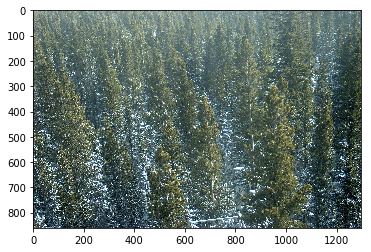

In [69]:
plt.imshow(data['image'][0,:,:,:])